In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:oracle.run2.framed",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 154325,
    "seed": 154325,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1400], examples_per_second: 695.8027, train_label_loss: 2.7989, 


epoch: 1, [batch: 140 / 1400], examples_per_second: 14344.5974, train_label_loss: 2.6342, 


epoch: 1, [batch: 280 / 1400], examples_per_second: 14152.3206, train_label_loss: 2.6001, 


epoch: 1, [batch: 420 / 1400], examples_per_second: 14028.7361, train_label_loss: 2.4267, 


epoch: 1, [batch: 560 / 1400], examples_per_second: 14062.7452, train_label_loss: 2.3107, 


epoch: 1, [batch: 700 / 1400], examples_per_second: 11764.4938, train_label_loss: 2.1286, 


epoch: 1, [batch: 840 / 1400], examples_per_second: 11688.9924, train_label_loss: 2.1026, 


epoch: 1, [batch: 980 / 1400], examples_per_second: 11680.3477, train_label_loss: 1.7981, 


epoch: 1, [batch: 1120 / 1400], examples_per_second: 11695.6204, train_label_loss: 1.8066, 


epoch: 1, [batch: 1260 / 1400], examples_per_second: 11696.6451, train_label_loss: 1.6244, 


epoch: 1, source_val_acc_label: 0.4838, source_val_label_loss: 1.5992, target_val_acc_label: 0.4838, target_val_label_loss: 1.5992, 


New best
epoch: 2, [batch: 1 / 1400], examples_per_second: 55.3074, train_label_loss: 1.7058, 


epoch: 2, [batch: 140 / 1400], examples_per_second: 11348.1323, train_label_loss: 1.3839, 


epoch: 2, [batch: 280 / 1400], examples_per_second: 11674.7687, train_label_loss: 1.3272, 


epoch: 2, [batch: 420 / 1400], examples_per_second: 11479.9566, train_label_loss: 1.3317, 


epoch: 2, [batch: 560 / 1400], examples_per_second: 11673.7044, train_label_loss: 1.1879, 


epoch: 2, [batch: 700 / 1400], examples_per_second: 11715.4910, train_label_loss: 1.0449, 


epoch: 2, [batch: 840 / 1400], examples_per_second: 11734.7129, train_label_loss: 0.9997, 


epoch: 2, [batch: 980 / 1400], examples_per_second: 11684.2298, train_label_loss: 0.8611, 


epoch: 2, [batch: 1120 / 1400], examples_per_second: 11701.0079, train_label_loss: 0.8596, 


epoch: 2, [batch: 1260 / 1400], examples_per_second: 11573.2446, train_label_loss: 0.6889, 


epoch: 2, source_val_acc_label: 0.8145, source_val_label_loss: 0.7042, target_val_acc_label: 0.8145, target_val_label_loss: 0.7042, 


New best
epoch: 3, [batch: 1 / 1400], examples_per_second: 62.7055, train_label_loss: 0.5913, 


epoch: 3, [batch: 140 / 1400], examples_per_second: 11595.9669, train_label_loss: 0.6302, 


epoch: 3, [batch: 280 / 1400], examples_per_second: 11658.0566, train_label_loss: 0.7251, 


epoch: 3, [batch: 420 / 1400], examples_per_second: 11567.6767, train_label_loss: 0.4716, 


epoch: 3, [batch: 560 / 1400], examples_per_second: 11604.2078, train_label_loss: 0.4771, 


epoch: 3, [batch: 700 / 1400], examples_per_second: 11499.7375, train_label_loss: 0.6391, 


epoch: 3, [batch: 840 / 1400], examples_per_second: 11681.6112, train_label_loss: 0.4756, 


epoch: 3, [batch: 980 / 1400], examples_per_second: 11717.3941, train_label_loss: 0.5992, 


epoch: 3, [batch: 1120 / 1400], examples_per_second: 11698.9372, train_label_loss: 0.4269, 


epoch: 3, [batch: 1260 / 1400], examples_per_second: 11639.1173, train_label_loss: 0.3674, 


epoch: 3, source_val_acc_label: 0.9027, source_val_label_loss: 0.3780, target_val_acc_label: 0.9027, target_val_label_loss: 0.3780, 


New best
epoch: 4, [batch: 1 / 1400], examples_per_second: 64.7341, train_label_loss: 0.5189, 


epoch: 4, [batch: 140 / 1400], examples_per_second: 12234.9075, train_label_loss: 0.3803, 


epoch: 4, [batch: 280 / 1400], examples_per_second: 11801.2189, train_label_loss: 0.3474, 


epoch: 4, [batch: 420 / 1400], examples_per_second: 11701.4925, train_label_loss: 0.3765, 


epoch: 4, [batch: 560 / 1400], examples_per_second: 11613.3412, train_label_loss: 0.3753, 


epoch: 4, [batch: 700 / 1400], examples_per_second: 11597.8011, train_label_loss: 0.3847, 


epoch: 4, [batch: 840 / 1400], examples_per_second: 11626.2806, train_label_loss: 0.3101, 


epoch: 4, [batch: 980 / 1400], examples_per_second: 11635.7550, train_label_loss: 0.3755, 


epoch: 4, [batch: 1120 / 1400], examples_per_second: 11615.1413, train_label_loss: 0.2508, 


epoch: 4, [batch: 1260 / 1400], examples_per_second: 11630.7999, train_label_loss: 0.2504, 


epoch: 4, source_val_acc_label: 0.8985, source_val_label_loss: 0.3328, target_val_acc_label: 0.8985, target_val_label_loss: 0.3328, 


epoch: 5, [batch: 1 / 1400], examples_per_second: 65.2097, train_label_loss: 0.2404, 


epoch: 5, [batch: 140 / 1400], examples_per_second: 11598.9913, train_label_loss: 0.2743, 


epoch: 5, [batch: 280 / 1400], examples_per_second: 11734.9328, train_label_loss: 0.2953, 


epoch: 5, [batch: 420 / 1400], examples_per_second: 11598.8141, train_label_loss: 0.2499, 


epoch: 5, [batch: 560 / 1400], examples_per_second: 11693.2368, train_label_loss: 0.1907, 


epoch: 5, [batch: 700 / 1400], examples_per_second: 11680.0337, train_label_loss: 0.2605, 


epoch: 5, [batch: 840 / 1400], examples_per_second: 11657.0043, train_label_loss: 0.2025, 


epoch: 5, [batch: 980 / 1400], examples_per_second: 11663.2902, train_label_loss: 0.2718, 


epoch: 5, [batch: 1120 / 1400], examples_per_second: 11660.6719, train_label_loss: 0.2045, 


epoch: 5, [batch: 1260 / 1400], examples_per_second: 11698.9845, train_label_loss: 0.2204, 


epoch: 5, source_val_acc_label: 0.9276, source_val_label_loss: 0.2554, target_val_acc_label: 0.9276, target_val_label_loss: 0.2554, 


New best
epoch: 6, [batch: 1 / 1400], examples_per_second: 64.1856, train_label_loss: 0.2175, 


epoch: 6, [batch: 140 / 1400], examples_per_second: 11691.1705, train_label_loss: 0.2160, 


epoch: 6, [batch: 280 / 1400], examples_per_second: 11693.6625, train_label_loss: 0.1836, 


epoch: 6, [batch: 420 / 1400], examples_per_second: 11684.6603, train_label_loss: 0.2291, 


epoch: 6, [batch: 560 / 1400], examples_per_second: 11702.3233, train_label_loss: 0.2104, 


epoch: 6, [batch: 700 / 1400], examples_per_second: 11745.9691, train_label_loss: 0.2401, 


epoch: 6, [batch: 840 / 1400], examples_per_second: 11716.8845, train_label_loss: 0.2082, 


epoch: 6, [batch: 980 / 1400], examples_per_second: 11710.7031, train_label_loss: 0.3897, 


epoch: 6, [batch: 1120 / 1400], examples_per_second: 11689.1342, train_label_loss: 0.1849, 


epoch: 6, [batch: 1260 / 1400], examples_per_second: 11753.4264, train_label_loss: 0.2971, 


epoch: 6, source_val_acc_label: 0.9373, source_val_label_loss: 0.2446, target_val_acc_label: 0.9373, target_val_label_loss: 0.2446, 


New best
epoch: 7, [batch: 1 / 1400], examples_per_second: 63.8679, train_label_loss: 0.2900, 


epoch: 7, [batch: 140 / 1400], examples_per_second: 11630.1285, train_label_loss: 0.2180, 


epoch: 7, [batch: 280 / 1400], examples_per_second: 11687.6292, train_label_loss: 0.2261, 


epoch: 7, [batch: 420 / 1400], examples_per_second: 11612.4387, train_label_loss: 0.1766, 


epoch: 7, [batch: 560 / 1400], examples_per_second: 11722.6171, train_label_loss: 0.1430, 


epoch: 7, [batch: 700 / 1400], examples_per_second: 11684.8110, train_label_loss: 0.2278, 


epoch: 7, [batch: 840 / 1400], examples_per_second: 11760.5233, train_label_loss: 0.2137, 


epoch: 7, [batch: 980 / 1400], examples_per_second: 11601.9921, train_label_loss: 0.2760, 


epoch: 7, [batch: 1120 / 1400], examples_per_second: 11738.8696, train_label_loss: 0.1622, 


epoch: 7, [batch: 1260 / 1400], examples_per_second: 11696.0954, train_label_loss: 0.3139, 


epoch: 7, source_val_acc_label: 0.9380, source_val_label_loss: 0.2113, target_val_acc_label: 0.9380, target_val_label_loss: 0.2113, 


New best
epoch: 8, [batch: 1 / 1400], examples_per_second: 64.6610, train_label_loss: 0.2368, 


epoch: 8, [batch: 140 / 1400], examples_per_second: 11634.9536, train_label_loss: 0.1314, 


epoch: 8, [batch: 280 / 1400], examples_per_second: 11758.1352, train_label_loss: 0.2158, 


epoch: 8, [batch: 420 / 1400], examples_per_second: 11684.7111, train_label_loss: 0.2035, 


epoch: 8, [batch: 560 / 1400], examples_per_second: 11699.9697, train_label_loss: 0.2165, 


epoch: 8, [batch: 700 / 1400], examples_per_second: 11658.4653, train_label_loss: 0.1764, 


epoch: 8, [batch: 840 / 1400], examples_per_second: 11642.4724, train_label_loss: 0.1288, 


epoch: 8, [batch: 980 / 1400], examples_per_second: 11719.4057, train_label_loss: 0.2235, 


epoch: 8, [batch: 1120 / 1400], examples_per_second: 11691.8035, train_label_loss: 0.1497, 


epoch: 8, [batch: 1260 / 1400], examples_per_second: 11687.3311, train_label_loss: 0.1669, 


epoch: 8, source_val_acc_label: 0.9529, source_val_label_loss: 0.1630, target_val_acc_label: 0.9529, target_val_label_loss: 0.1630, 


New best
epoch: 9, [batch: 1 / 1400], examples_per_second: 64.4965, train_label_loss: 0.1389, 


epoch: 9, [batch: 140 / 1400], examples_per_second: 11668.0447, train_label_loss: 0.1419, 


epoch: 9, [batch: 280 / 1400], examples_per_second: 11750.6426, train_label_loss: 0.1467, 


epoch: 9, [batch: 420 / 1400], examples_per_second: 11668.0213, train_label_loss: 0.1795, 


epoch: 9, [batch: 560 / 1400], examples_per_second: 11752.2778, train_label_loss: 0.0996, 


epoch: 9, [batch: 700 / 1400], examples_per_second: 11688.8742, train_label_loss: 0.1448, 


epoch: 9, [batch: 840 / 1400], examples_per_second: 11689.4232, train_label_loss: 0.1478, 


epoch: 9, [batch: 980 / 1400], examples_per_second: 11572.6957, train_label_loss: 0.3070, 


epoch: 9, [batch: 1120 / 1400], examples_per_second: 11710.8473, train_label_loss: 0.1556, 


epoch: 9, [batch: 1260 / 1400], examples_per_second: 11682.8495, train_label_loss: 0.1483, 


epoch: 9, source_val_acc_label: 0.9483, source_val_label_loss: 0.1602, target_val_acc_label: 0.9483, target_val_label_loss: 0.1602, 


epoch: 10, [batch: 1 / 1400], examples_per_second: 65.8521, train_label_loss: 0.1322, 


epoch: 10, [batch: 140 / 1400], examples_per_second: 11722.9102, train_label_loss: 0.1302, 


epoch: 10, [batch: 280 / 1400], examples_per_second: 11744.0897, train_label_loss: 0.0893, 


epoch: 10, [batch: 420 / 1400], examples_per_second: 11699.9861, train_label_loss: 0.0947, 


epoch: 10, [batch: 560 / 1400], examples_per_second: 11695.1509, train_label_loss: 0.1387, 


epoch: 10, [batch: 700 / 1400], examples_per_second: 11693.7371, train_label_loss: 0.1413, 


epoch: 10, [batch: 840 / 1400], examples_per_second: 11743.0439, train_label_loss: 0.1703, 


epoch: 10, [batch: 980 / 1400], examples_per_second: 11694.8633, train_label_loss: 0.2360, 


epoch: 10, [batch: 1120 / 1400], examples_per_second: 12289.6663, train_label_loss: 0.1357, 


epoch: 10, [batch: 1260 / 1400], examples_per_second: 12296.6592, train_label_loss: 0.0819, 


epoch: 10, source_val_acc_label: 0.9509, source_val_label_loss: 0.1670, target_val_acc_label: 0.9509, target_val_label_loss: 0.1670, 


epoch: 11, [batch: 1 / 1400], examples_per_second: 71.8191, train_label_loss: 0.1259, 


epoch: 11, [batch: 140 / 1400], examples_per_second: 12629.4647, train_label_loss: 0.1419, 


epoch: 11, [batch: 280 / 1400], examples_per_second: 12411.8638, train_label_loss: 0.0911, 


epoch: 11, [batch: 420 / 1400], examples_per_second: 12457.1408, train_label_loss: 0.2335, 


epoch: 11, [batch: 560 / 1400], examples_per_second: 11008.9089, train_label_loss: 0.0919, 


epoch: 11, [batch: 700 / 1400], examples_per_second: 10671.7413, train_label_loss: 0.2065, 


epoch: 11, [batch: 840 / 1400], examples_per_second: 10618.4116, train_label_loss: 0.1035, 


epoch: 11, [batch: 980 / 1400], examples_per_second: 10698.2321, train_label_loss: 0.1081, 


epoch: 11, [batch: 1120 / 1400], examples_per_second: 10667.3687, train_label_loss: 0.1236, 


epoch: 11, [batch: 1260 / 1400], examples_per_second: 10665.5553, train_label_loss: 0.1445, 


epoch: 11, source_val_acc_label: 0.9581, source_val_label_loss: 0.1402, target_val_acc_label: 0.9581, target_val_label_loss: 0.1402, 


New best
epoch: 12, [batch: 1 / 1400], examples_per_second: 56.3861, train_label_loss: 0.0788, 


epoch: 12, [batch: 140 / 1400], examples_per_second: 10529.9257, train_label_loss: 0.1076, 


epoch: 12, [batch: 280 / 1400], examples_per_second: 10672.4853, train_label_loss: 0.1812, 


epoch: 12, [batch: 420 / 1400], examples_per_second: 10598.8459, train_label_loss: 0.1655, 


epoch: 12, [batch: 560 / 1400], examples_per_second: 10657.2121, train_label_loss: 0.1542, 


epoch: 12, [batch: 700 / 1400], examples_per_second: 10652.6505, train_label_loss: 0.0805, 


epoch: 12, [batch: 840 / 1400], examples_per_second: 10620.9534, train_label_loss: 0.0900, 


epoch: 12, [batch: 980 / 1400], examples_per_second: 10699.7871, train_label_loss: 0.1064, 


epoch: 12, [batch: 1120 / 1400], examples_per_second: 10687.3860, train_label_loss: 0.1191, 


epoch: 12, [batch: 1260 / 1400], examples_per_second: 10712.2735, train_label_loss: 0.1044, 


epoch: 12, source_val_acc_label: 0.9508, source_val_label_loss: 0.1464, target_val_acc_label: 0.9508, target_val_label_loss: 0.1464, 


epoch: 13, [batch: 1 / 1400], examples_per_second: 57.3782, train_label_loss: 0.1246, 


epoch: 13, [batch: 140 / 1400], examples_per_second: 10639.5254, train_label_loss: 0.0527, 


epoch: 13, [batch: 280 / 1400], examples_per_second: 10660.3576, train_label_loss: 0.1154, 


epoch: 13, [batch: 420 / 1400], examples_per_second: 10672.2853, train_label_loss: 0.1242, 


epoch: 13, [batch: 560 / 1400], examples_per_second: 10653.5897, train_label_loss: 0.0993, 


epoch: 13, [batch: 700 / 1400], examples_per_second: 10571.1744, train_label_loss: 0.0892, 


epoch: 13, [batch: 840 / 1400], examples_per_second: 10558.7788, train_label_loss: 0.1850, 


epoch: 13, [batch: 980 / 1400], examples_per_second: 10607.9168, train_label_loss: 0.0991, 


epoch: 13, [batch: 1120 / 1400], examples_per_second: 10657.1834, train_label_loss: 0.0987, 


epoch: 13, [batch: 1260 / 1400], examples_per_second: 10659.0090, train_label_loss: 0.2368, 


epoch: 13, source_val_acc_label: 0.9552, source_val_label_loss: 0.2047, target_val_acc_label: 0.9552, target_val_label_loss: 0.2047, 


epoch: 14, [batch: 1 / 1400], examples_per_second: 57.8877, train_label_loss: 0.1141, 


epoch: 14, [batch: 140 / 1400], examples_per_second: 10519.0785, train_label_loss: 0.1468, 


epoch: 14, [batch: 280 / 1400], examples_per_second: 10666.0804, train_label_loss: 0.1560, 


epoch: 14, [batch: 420 / 1400], examples_per_second: 10643.5075, train_label_loss: 0.0866, 


epoch: 14, [batch: 560 / 1400], examples_per_second: 10647.5831, train_label_loss: 0.1128, 


epoch: 14, [batch: 700 / 1400], examples_per_second: 10683.9633, train_label_loss: 0.1209, 


epoch: 14, [batch: 840 / 1400], examples_per_second: 10648.6662, train_label_loss: 0.1274, 


epoch: 14, [batch: 980 / 1400], examples_per_second: 10664.6457, train_label_loss: 0.1283, 


epoch: 14, [batch: 1120 / 1400], examples_per_second: 10688.4742, train_label_loss: 0.1021, 


epoch: 14, [batch: 1260 / 1400], examples_per_second: 10682.1913, train_label_loss: 0.0875, 


epoch: 14, source_val_acc_label: 0.9614, source_val_label_loss: 0.1676, target_val_acc_label: 0.9614, target_val_label_loss: 0.1676, 


New best
epoch: 15, [batch: 1 / 1400], examples_per_second: 57.1847, train_label_loss: 0.1112, 


epoch: 15, [batch: 140 / 1400], examples_per_second: 10660.5122, train_label_loss: 0.0645, 


epoch: 15, [batch: 280 / 1400], examples_per_second: 10621.0645, train_label_loss: 0.0860, 


epoch: 15, [batch: 420 / 1400], examples_per_second: 10640.0903, train_label_loss: 0.0882, 


epoch: 15, [batch: 560 / 1400], examples_per_second: 10651.5923, train_label_loss: 0.0789, 


epoch: 15, [batch: 700 / 1400], examples_per_second: 10650.3818, train_label_loss: 0.0805, 


epoch: 15, [batch: 840 / 1400], examples_per_second: 10576.4834, train_label_loss: 0.1211, 


epoch: 15, [batch: 980 / 1400], examples_per_second: 10618.6457, train_label_loss: 0.0912, 


epoch: 15, [batch: 1120 / 1400], examples_per_second: 10594.1864, train_label_loss: 0.1263, 


epoch: 15, [batch: 1260 / 1400], examples_per_second: 10572.7046, train_label_loss: 0.0854, 


epoch: 15, source_val_acc_label: 0.9595, source_val_label_loss: 0.1755, target_val_acc_label: 0.9595, target_val_label_loss: 0.1755, 


epoch: 16, [batch: 1 / 1400], examples_per_second: 56.6838, train_label_loss: 0.0515, 


epoch: 16, [batch: 140 / 1400], examples_per_second: 10601.3548, train_label_loss: 0.0463, 


epoch: 16, [batch: 280 / 1400], examples_per_second: 10642.4586, train_label_loss: 0.2748, 


epoch: 16, [batch: 420 / 1400], examples_per_second: 10602.8230, train_label_loss: 0.1198, 


epoch: 16, [batch: 560 / 1400], examples_per_second: 10655.7087, train_label_loss: 0.0980, 


epoch: 16, [batch: 700 / 1400], examples_per_second: 10684.5648, train_label_loss: 0.0624, 


epoch: 16, [batch: 840 / 1400], examples_per_second: 10681.7845, train_label_loss: 0.0654, 


epoch: 16, [batch: 980 / 1400], examples_per_second: 10654.1772, train_label_loss: 0.1121, 


epoch: 16, [batch: 1120 / 1400], examples_per_second: 10569.2762, train_label_loss: 0.1147, 


epoch: 16, [batch: 1260 / 1400], examples_per_second: 10657.9042, train_label_loss: 0.1066, 


epoch: 16, source_val_acc_label: 0.9652, source_val_label_loss: 0.1165, target_val_acc_label: 0.9652, target_val_label_loss: 0.1165, 


New best
epoch: 17, [batch: 1 / 1400], examples_per_second: 55.6395, train_label_loss: 0.1087, 


epoch: 17, [batch: 140 / 1400], examples_per_second: 10583.8038, train_label_loss: 0.2093, 


epoch: 17, [batch: 280 / 1400], examples_per_second: 10658.4029, train_label_loss: 0.0746, 


epoch: 17, [batch: 420 / 1400], examples_per_second: 10666.3923, train_label_loss: 0.0699, 


epoch: 17, [batch: 560 / 1400], examples_per_second: 10659.7770, train_label_loss: 0.0768, 


epoch: 17, [batch: 700 / 1400], examples_per_second: 10674.3936, train_label_loss: 0.0798, 


epoch: 17, [batch: 840 / 1400], examples_per_second: 10629.3557, train_label_loss: 0.0723, 


epoch: 17, [batch: 980 / 1400], examples_per_second: 10671.3261, train_label_loss: 0.1557, 


epoch: 17, [batch: 1120 / 1400], examples_per_second: 10664.8909, train_label_loss: 0.1202, 


epoch: 17, [batch: 1260 / 1400], examples_per_second: 10654.4248, train_label_loss: 0.1010, 


epoch: 17, source_val_acc_label: 0.9646, source_val_label_loss: 0.1121, target_val_acc_label: 0.9646, target_val_label_loss: 0.1121, 


epoch: 18, [batch: 1 / 1400], examples_per_second: 57.3618, train_label_loss: 0.1057, 


epoch: 18, [batch: 140 / 1400], examples_per_second: 10623.4084, train_label_loss: 0.0844, 


epoch: 18, [batch: 280 / 1400], examples_per_second: 10577.4286, train_label_loss: 0.0429, 


epoch: 18, [batch: 420 / 1400], examples_per_second: 10647.6766, train_label_loss: 0.1056, 


epoch: 18, [batch: 560 / 1400], examples_per_second: 10651.0851, train_label_loss: 0.0734, 


epoch: 18, [batch: 700 / 1400], examples_per_second: 10657.9495, train_label_loss: 0.0645, 


epoch: 18, [batch: 840 / 1400], examples_per_second: 10699.4718, train_label_loss: 0.0903, 


epoch: 18, [batch: 980 / 1400], examples_per_second: 10682.4828, train_label_loss: 0.0779, 


epoch: 18, [batch: 1120 / 1400], examples_per_second: 10646.9209, train_label_loss: 0.0603, 


epoch: 18, [batch: 1260 / 1400], examples_per_second: 10705.6241, train_label_loss: 0.0745, 


epoch: 18, source_val_acc_label: 0.9622, source_val_label_loss: 0.1100, target_val_acc_label: 0.9622, target_val_label_loss: 0.1100, 


epoch: 19, [batch: 1 / 1400], examples_per_second: 58.0306, train_label_loss: 0.0528, 


epoch: 19, [batch: 140 / 1400], examples_per_second: 10654.0165, train_label_loss: 0.0545, 


epoch: 19, [batch: 280 / 1400], examples_per_second: 10602.7422, train_label_loss: 0.3551, 


epoch: 19, [batch: 420 / 1400], examples_per_second: 10535.3591, train_label_loss: 0.0604, 


epoch: 19, [batch: 560 / 1400], examples_per_second: 10586.8804, train_label_loss: 0.0741, 


epoch: 19, [batch: 700 / 1400], examples_per_second: 10643.0885, train_label_loss: 0.1789, 


epoch: 19, [batch: 840 / 1400], examples_per_second: 10675.1364, train_label_loss: 0.0400, 


epoch: 19, [batch: 980 / 1400], examples_per_second: 10653.8947, train_label_loss: 0.0853, 


epoch: 19, [batch: 1120 / 1400], examples_per_second: 10699.4581, train_label_loss: 0.1227, 


epoch: 19, [batch: 1260 / 1400], examples_per_second: 10647.9918, train_label_loss: 0.0602, 


epoch: 19, source_val_acc_label: 0.9535, source_val_label_loss: 0.1706, target_val_acc_label: 0.9535, target_val_label_loss: 0.1706, 


epoch: 20, [batch: 1 / 1400], examples_per_second: 56.8408, train_label_loss: 0.0911, 


epoch: 20, [batch: 140 / 1400], examples_per_second: 10496.4322, train_label_loss: 0.0757, 


epoch: 20, [batch: 280 / 1400], examples_per_second: 10682.0835, train_label_loss: 0.0363, 


epoch: 20, [batch: 420 / 1400], examples_per_second: 10585.6667, train_label_loss: 0.0599, 


epoch: 20, [batch: 560 / 1400], examples_per_second: 10687.1307, train_label_loss: 0.0821, 


epoch: 20, [batch: 700 / 1400], examples_per_second: 10714.8421, train_label_loss: 0.0493, 


epoch: 20, [batch: 840 / 1400], examples_per_second: 10630.1780, train_label_loss: 0.0869, 


epoch: 20, [batch: 980 / 1400], examples_per_second: 10616.2534, train_label_loss: 0.0712, 


epoch: 20, [batch: 1120 / 1400], examples_per_second: 10740.8200, train_label_loss: 0.1073, 


epoch: 20, [batch: 1260 / 1400], examples_per_second: 10708.1544, train_label_loss: 0.1095, 


epoch: 20, source_val_acc_label: 0.9627, source_val_label_loss: 0.1132, target_val_acc_label: 0.9627, target_val_label_loss: 0.1132, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

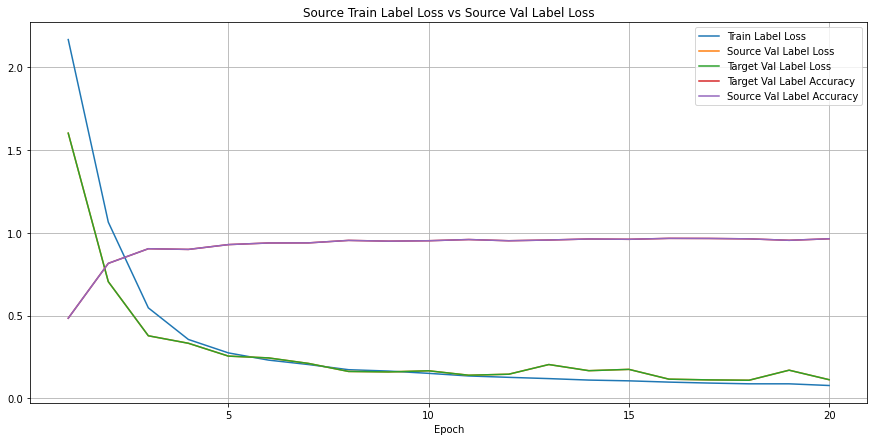

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

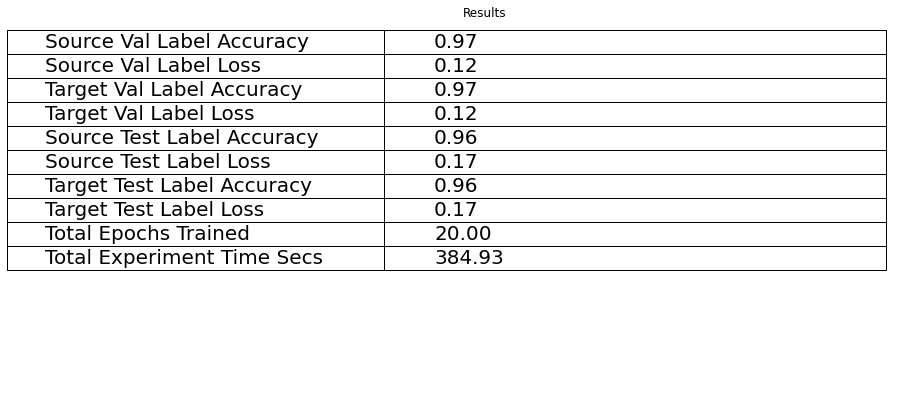

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

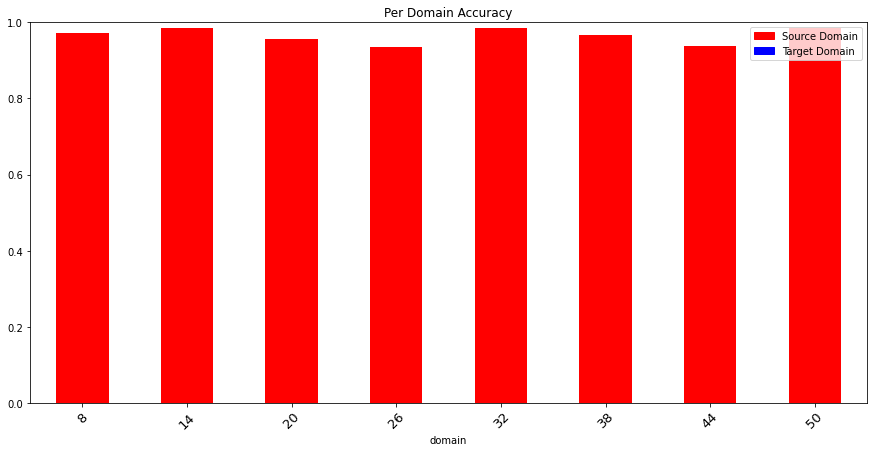

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9643489583333333 Target Test Label Accuracy: 0.9643489583333333
Source Val Label Accuracy: 0.9651822916666667 Target Val Label Accuracy: 0.9651822916666667


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:oracle.run2.framed", "parameters": {"experiment_name": "cnn_2:oracle.run2.framed", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_ch